In [13]:
import sys
sys.path.append("../../src/earthtext")

import rasterio
import xarray as xr
import os
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from osm import osm
from collections import OrderedDict
import pandas as pd
get_region_hash = osm.get_region_hash

In [14]:
imgs_folder    = "/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips"
osmobjs_folder = "/opt/data/california-worldcover-chips/osm"
master_index   = "/opt/data/california-worldcover-chips.fgb"

In [92]:
class ImageOSMData:

    def __init__(self, imgs_folder, osmobjs_folder, master_index):
        self.imgs_folder = imgs_folder
        self.osmobjs_folder = osmobjs_folder
        self.master_index = master_index

    def init_index(self):
        self.m = gpd.read_file(master_index)
        self.m.index = [get_region_hash(gi) for gi in self.m.geometry.values]
        return self

    def sample_chip(self):
        chip_id = self.m.index[np.random.randint(len(self.m))]
        return ImageOSMChip(self, chip_id)
    
class ImageOSMChip:

    def __init__(self, iosmdata, chip_id):

        self.iosmdata = iosmdata
        self.chip_id = chip_id
        
    def read_osm(self, min_area=0):
        """
        reads the osm objects for this chip id, cleaning up key/values
        """
        if not self.chip_id in self.iosmdata.m.index:
            raise ValueError(f"chip {self.chip_id} not indexed")
            
        try:
            z = gpd.read_parquet(f"{self.iosmdata.osmobjs_folder}/{self.chip_id}.parquet")
            z['tags'] = [eval(i) if isinstance(i, str) else i for i in z.tags]
            z['tags'] = [osm.clean_tags(t) for t in z.tags]
            z = z[[len(t)>0 for t in z['tags']]]
            z = z[z['area']>=min_area]
    
            if len(z)==0:
                self.osm = None
            else:
                self.osm = z.copy()
        except:
            self.osm = None

        return self

    def read_img(self):
        if not self.chip_id in self.iosmdata.m.index:
            raise ValueError(f"chip {self.chip_id} not indexed")
            
        mi = self.iosmdata.m.loc[self.chip_id]
        fname = f"{self.iosmdata.imgs_folder}/worldcover_california_chip_{mi['col']}_{mi['row']}.tif"
        
        with xr.open_dataarray(fname) as z:
            self.img = z.data.copy()

        return self

    def get_keyvals_count(self):
        """
        counts the occurrences of key/vals in the osm objects of this chip

        returns: a dictionary with the count of each key/val
        """
        r = []
        for _,o in self.osm.iterrows():
            if o.kind=='node':
                continue
            if o.area>0:
                # this is a closed way
                keep_keyvalues = osm_keyvals_closedways
            else:
                # this is an open way
                keep_keyvalues = osm_keyvals_openways
                
            for k,v in o['tags'].items():
                if k in keep_keyvalues and v in keep_keyvalues[k]:
                    r.append(f"{k}={v}")
                    if not k in r:
                        r.append(k)
        return pd.Series(r).value_counts()
    
    def show(self):
        for ax, i in subplots(len(self.img), n_cols=6, usizex=4):
            _x = self.img[i]
            a,b = np.percentile(_x, [1,99])
            plt.imshow(_x, vmin=a, vmax=b)
            plt.colorbar()
            if i==0:
                plt.title(self.chip_id)

    def get_keyvalue_codes(self, keyvaluecodes):
        ## TODO: distinguish open ways from closed ways
        return [i for j in [keyvaluecodes.get_codes(ti) for ti in self.osm.tags] for i in j]
    
class OSMKeyValueCodes:

    def __init__(self):
        osm_keyvals_closedways = {}
        osm_keyvals_closedways['landuse']  = ['residential', 'grass', 'farmland', 'meadow', 'commercial', 'orchard', 'vineyard', 'industrial', 
                                               'retail', 'farmyard', 'forest', 'military', 'farm', 'cemetery', 'brownfield', 'quarry', 'greenfield']
        osm_keyvals_closedways['natural']  = ['water', 'wood', 'scrub', 'sand', 'grassland', 'wetland', 'bare_rock', 'coastline', 'heath', 'valley', 
                                              'desert', 'cliff', 'scree', 'beach', 'mountain_range', 'mud', 'bay']
        osm_keyvals_closedways['leisure']  = ['pitch', 'park', 'garden', 'nature_reserve', 'sports_centre', 'golf_course', 'track', 'schoolyard', 'stadium']
        osm_keyvals_closedways['water']    = ['pond', 'reservoir', 'lake', 'river', 'canal', 'wastewater', 'stream', 'ditch', 'stream;river']
        osm_keyvals_closedways['sport']    = ['baseball', 'soccer', 'american_football', 'running', 'equestrian', 'athletics', 'motor', 'multi']
        osm_keyvals_closedways['building'] = ['house', 'residential', 'apartments', 'industrial', 'school', 'warehouse']
        osm_keyvals_closedways['surface']  = ['asphalt', 'concrete', 'paved', 'gravel', 'sand', 'grass']
        osm_keyvals_closedways['crop']     = ['grape', 'field_cropland', 'WINE GRAPES', 'native_pasture']
        osm_keyvals_closedways['power']    = ['generator', 'substation', 'plant']
        osm_keyvals_closedways['parking']  = ['surface', 'multi-storey']
        osm_keyvals_closedways['highway']  = ['track']
        osm_keyvals_closedways['waterway'] = ['dam']
        osm_keyvals_closedways['amenity']  = ['parking']
        
        
        osm_keyvals_openways = {}
        osm_keyvals_openways['highway']  = ['motorway']
        osm_keyvals_openways['waterway'] = ['stream']
        osm_keyvals_openways['waterway'] = ['river']

        # maps to remove duplicated and standardize
        osm_keyvals_closedways = {k: list(set([self.map_keyval(k,vi)[1] for vi in v])) for k,v in osm_keyvals_closedways.items()}
        osm_keyvals_openways   = {k: list(set([self.map_keyval(k,vi)[1] for vi in v])) for k,v in osm_keyvals_openways.items()}
        
        # assign a seq number to each keyval pair, including each single key (with no val)
        self.closed_keyvals = [f"{k}={v}" for k in osm_keyvals_closedways.keys() for v in sorted(osm_keyvals_closedways[k]) ] + list(osm_keyvals_closedways.keys())
        self.open_keyvals   = [f"{k}={v}" for k in osm_keyvals_openways.keys()   for v in sorted(osm_keyvals_openways[k]) ] + list(osm_keyvals_openways.keys())
        
        self.osm_keyvals_closedways = osm_keyvals_closedways
        self.osm_keyvals_openways = osm_keyvals_openways

        # assigned a code to each keyvalue pair
        self.keyvals_codes = {k:i for i,k in enumerate(sorted(self.closed_keyvals + self.open_keyvals))}

    def map_keyval(self, key, val):
        """
        maps keyvals to remove duplicates, standardize, etc.
        
        keyvals: a dict with osm key values
        """
        k,v = key,val
        if k=='crop' and v=='WINE GRAPES':
            return 'crop', 'grape'
        if k=='water' and v=='stream;river':
            return 'water', 'stream'
        return k,v
                
    def get_codes(self, keyvals):
        """
        returns a list of codes, one for each key/value pair in the input dictionary
        including a code for each single key (with no value)
        
        keyvals: a dictionary
        """
        r = []
        for k in keyvals.keys():
            if k in self.keyvals_codes.keys():
                r.append(self.keyvals_codes[k])
                     
        for k,v in keyvals.items():
            k,v = self.map_keyval(k,v)
            kvstring = f'{k}={v}'
            if kvstring in self.keyvals_codes.keys():
                code  = self.keyvals_codes[kvstring]
                r.append(code)
        return r  


In [93]:
kv = OSMKeyValueCodes()

In [21]:
iosdata = ImageOSMData(imgs_folder=imgs_folder, osmobjs_folder=osmobjs_folder, master_index=master_index).init_index()

In [94]:
    def sample_chip(self):
        chip_id = self.m.index[np.random.randint(len(self.m))]
        return ImageOSMChip(self, chip_id)


In [95]:
c = sample_chip(iosdata).read_img().read_osm()

In [96]:
c.osm

,tags,geometry,kind,length,area,stags,chip_id
334,{'highway': 'track'},"LINESTRING (-121.82740 38.37333, -121.82743 38...",way,2377.389715,0.00000,highway: track,27cd2754f6def
461,{'highway': 'residential'},"LINESTRING (-121.84267 38.37675, -121.84138 38...",way,899.592961,0.00000,highway: residential,27cd2754f6def
465,{'highway': 'track'},"LINESTRING (-121.82285 38.38153, -121.82242 38...",way,133.842045,0.00000,highway: track,27cd2754f6def
467,{'highway': 'service'},"LINESTRING (-121.82283 38.38331, -121.82242 38...",way,72.764593,0.00000,highway: service,27cd2754f6def
480,{'highway': 'track'},"LINESTRING (-121.82133 38.37668, -121.82218 38...",way,137.654561,0.00000,highway: track,27cd2754f6def
875,{'highway': 'residential'},"LINESTRING (-121.84132 38.38398, -121.84267 38...",way,118.210134,0.00000,highway: residential,27cd2754f6def
982,{'highway': 'track'},"LINESTRING (-121.82379 38.37858, -121.82418 38...",way,723.787089,0.00000,highway: track,27cd2754f6def
1502,{'highway': 'residential'},"LINESTRING (-121.82281 38.39126, -121.82133 38...",way,129.180383,0.00000,highway: residential,27cd2754f6def
3442,{'landuse': 'farmyard'},"POLYGON ((-121.82262 38.38324, -121.82268 38.3...",way,3018.291944,135592.68027,description: other land\n<br>\nlanduse: farmyard,27cd2754f6def
3504,{'aeroway': 'aerodrome'},"POLYGON ((-121.82385 38.37636, -121.82381 38.3...",way,3018.291944,135592.68027,aeroway: aerodrome\n<br>\nsource_ref: geonames...,27cd2754f6def


In [101]:
c.get_keyvalue_codes(kv)

[14,
 16,
 14,
 14,
 16,
 14,
 14,
 16,
 14,
 14,
 16,
 14,
 17,
 23,
 17,
 32,
 14,
 14,
 79,
 14,
 14,
 14,
 14,
 14,
 16,
 14,
 14]

In [99]:
def get_keyvalue_codes(self, keyvaluecodes):
    return [i for j in [keyvaluecodes.get_keyval_codes(ti) for ti in self.osm.tags] for i in j]

In [100]:
get_keyvalue_codes(c, kv)

AttributeError: 'OSMKeyValueCodes' object has no attribute 'get_keyval_codes'

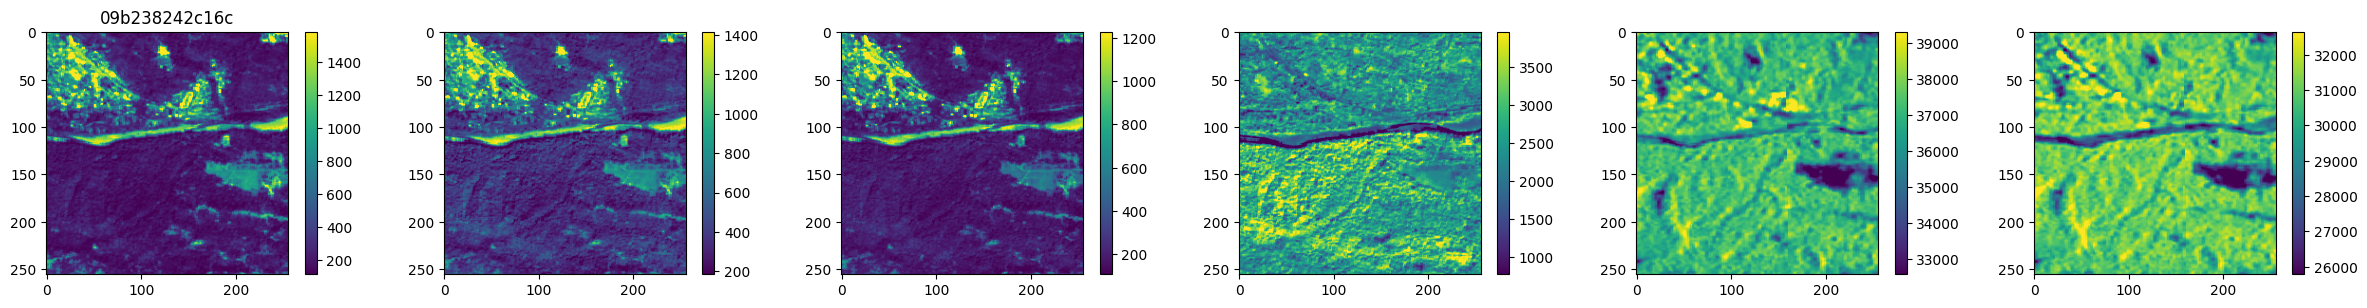

In [179]:
c.read_img().read_osm()
c.show()

In [243]:
self = c

def get_keyvals_count(self):
    r = []
    for _,o in self.osm.iterrows():
        if o.kind=='node':
            continue
        if o.area>0:
            # this is a closed way
            keep_keyvalues = osm_keyvals_closedways
        else:
            # this is an open way
            keep_keyvalues = osm_keyvals_openways
            
        for k,v in o['tags'].items():
            if k in keep_keyvalues and v in keep_keyvalues[k]:
                r.append(f"{k}={v}")
                if not k in r:
                    r.append(k)
    return pd.Series(r).value_counts()

In [260]:
get_keyvals_count(c)


Series([], Name: count, dtype: int64)

In [187]:
c.osm

,tags,geometry,kind,length,area,stags,chip_id
141030372,{'place': 'hamlet'},POINT (-123.82336 40.12014),node,0.000000,0.000000,place: hamlet,09b238242c16c
358818191,{'amenity': 'place_of_worship'},POINT (-123.82149 40.11703),node,0.000000,0.000000,amenity: place_of_worship\n<br>\ndenomination:...,09b238242c16c
358818199,{'amenity': 'place_of_worship'},POINT (-123.82253 40.12014),node,0.000000,0.000000,amenity: place_of_worship\n<br>\ndenomination:...,09b238242c16c
358818237,{'amenity': 'school'},POINT (-123.82420 40.11903),node,0.000000,0.000000,amenity: school,09b238242c16c
1328779418,{'shop': 'supermarket'},POINT (-123.82387 40.12022),node,0.000000,0.000000,shop: supermarket,09b238242c16c
...,...,...,...,...,...,...,...
3318,{'building': 'yes'},"POLYGON ((-123.82634 40.12033, -123.82634 40.1...",way,62.562941,204.680126,building: yes,09b238242c16c
3319,"{'amenity': 'place_of_worship', 'building': 'y...","POLYGON ((-123.82580 40.12065, -123.82567 40.1...",way,81.242189,362.451372,amenity: place_of_worship\n<br>\nbuilding: yes...,09b238242c16c
3742,{'building': 'yes'},"POLYGON ((-123.82167 40.12007, -123.82160 40.1...",way,94.210940,532.231079,building: yes,09b238242c16c
3746,"{'highway': 'service', 'surface': 'asphalt'}","LINESTRING (-123.82035 40.11793, -123.82077 40...",way,51.473750,0.000000,highway: service\n<br>\nsurface: asphalt,09b238242c16c


In [191]:
c.osm['tags'].value_counts()

tags
{'highway': 'residential'}                                                 53
{'building': 'yes'}                                                         9
{'highway': 'service'}                                                      7
{'waterway': 'stream'}                                                      6
{'highway': 'secondary'}                                                    4
{'leisure': 'pitch', 'sport': 'baseball'}                                   2
{'amenity': 'place_of_worship'}                                             2
{'place': 'hamlet'}                                                         1
{'highway': 'service', 'surface': 'asphalt'}                                1
{'amenity': 'place_of_worship', 'building': 'yes'}                          1
{'natural': 'grassland'}                                                    1
{'waterway': 'river'}                                                       1
{'highway': 'tertiary'}                                    

In [177]:
c.osm

In [67]:
m = gpd.read_file(master_index)

In [68]:
m['chip_id'] = [osm.get_region_hash(gi) for gi in m.geometry.values]

In [69]:
m.head()

,col,row,geometry,chip_id
0,131584,119552,"POLYGON ((-114.01333 32.01600, -114.01333 32.0...",272274b1ba17e
1,131584,119296,"POLYGON ((-114.01333 32.03733, -114.01333 32.0...",257760bda8ca7
2,131328,119296,"POLYGON ((-114.03467 32.03733, -114.03467 32.0...",0630b39477419
3,131328,119552,"POLYGON ((-114.03467 32.01600, -114.03467 32.0...",166f6e23d38eb
4,131072,119552,"POLYGON ((-114.05600 32.01600, -114.05600 32.0...",0cb98e9e9788e


In [70]:
def read_chip_osm(osmobjs_folder, chip_id, min_area=0):
    z = gpd.read_parquet(f"{osmobjs_folder}/{chip_id}.parquet")
    z['tags'] = [eval(i) if isinstance(i, str) else i for i in z.tags]
    z['tags'] = [osm.clean_tags(t) for t in z.tags]
    z = z[[len(t)>0 for t in z['tags']]]
    z = z[z['area']>=min_area]
    if len(z)==0:
        return None
    else:
        return z

In [81]:
chip_id = m.chip_id.values[np.random.randint(len(m))]
chip_id

'08d5bc2b57dbf'

In [82]:
zo = read_chip_osm(osmobjs_folder, chip_id, min_area=100)

In [83]:
zo

,tags,geometry,kind,length,area,stags,chip_id
81,{'landuse': 'disused:industrial'},"POLYGON ((-115.37297 35.47015, -115.36832 35.4...",way,2251.261323,296795.376709,landuse: disused:industrial,08d5bc2b57dbf
397,{'landuse': 'disused:industrial'},"POLYGON ((-115.37719 35.47016, -115.37297 35.4...",way,2176.319504,270166.105424,landuse: disused:industrial,08d5bc2b57dbf


In [31]:
imgchips = os.listdir(imgs_folder)
osmobjs  = os.listdir(osmobjs_folder)
len(imgchips), len(osmobjs)

(78179, 92440)

In [84]:
imgchips[0]

'worldcover_california_chip_100096_107264.tif'

In [27]:
fname = f"{imgs_folder}/{imgchips[1001]}"
with xr.open_dataarray(fname) as z:
    x = z.data.copy()

In [28]:
x.shape

(6, 256, 256)

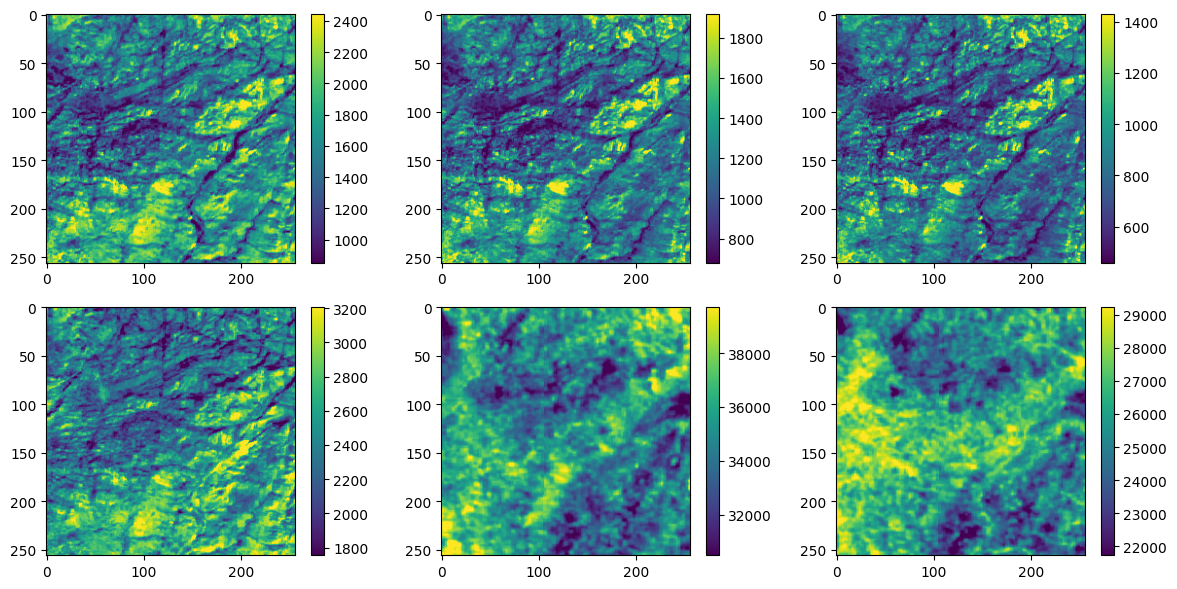

In [29]:
for ax, i in subplots(len(x), n_cols=3, usizex=4):
    _x = x[i]
    a,b = np.percentile(_x, [1,99])
    plt.imshow(_x, vmin=a, vmax=b)
    plt.colorbar()